In [14]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

from scipy.special import softmax
from sklearn.metrics.pairwise import cosine_similarity

from models.pipeline import Pipeline
from utils.view import draw_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def grid_to_latent(pipeline: Pipeline, grid, model_type="vq"):
    grid = pipeline.preprocess_and_compress(grid)
    if model_type == 'vq':
        z = pipeline.encode(grid.unsqueeze(0).to(device))
    else:
        z, _ = pipeline.encode(grid.unsqueeze(0).to(device))
    
    z_size = z.size()
    z_flat = z.view(z.size(0), -1)

    return z_flat, z_size
    # return grid, grid.size()

def latent_to_grid(pipeline: Pipeline, z, expected_output, model_type="vq"):
    if model_type == 'vq':
        z_quantized, _, _ = pipeline.model.quantize(z.to(device))
        decoded = pipeline.decode(z_quantized)
    else:
        decoded = pipeline.decode(z.unsqueeze(0).to(device))
        
    return pipeline.decompress_and_postprocess(decoded.squeeze(0), expected_output)
    # return pipeline.decompress_and_postprocess(z.squeeze(0), expected_output)

def process_train_pairs(pipeline: Pipeline, train_pairs, model_type="vq"):
    z_inputs = []
    z_diffs = []
    z_size = None
    for input, output in train_pairs:
        z_input, z_size = grid_to_latent(pipeline, input, model_type)
        z_output, _ = grid_to_latent(pipeline, output, model_type)
        z_inputs.append(z_input)
        z_diffs.append(z_output - z_input)
    
    return z_inputs, z_diffs, z_size

def extract_diff(z_diffs, z_inputs, z_test_input, comp="average"):
    if comp == 'average':
        return np.mean(z_diffs, axis=0)
    elif comp == 'scaled_euc':
        support_dists = [np.linalg.norm(support_z - z_test_input) for support_z in z_inputs]
        euc_weights = softmax(-np.array(support_dists))
        return np.sum([w * z for w, z in zip(euc_weights, z_diffs)], axis=0)
    elif comp == 'scaled_cos':
        z_inputs = np.array(z_inputs)
        if z_inputs.ndim > 2:
        # Flatten all dimensions after the first one
            z_inputs_2d = z_inputs.reshape(z_inputs.shape[0], -1)
        else:
            z_inputs_2d = z_inputs
            
        if z_test_input.ndim > 1:
            z_test_input_2d = z_test_input.reshape(1, -1)
        else:
            z_test_input_2d = z_test_input.reshape(1, -1)
        

        cos_sims = cosine_similarity(z_inputs_2d, z_test_input_2d).flatten()
        cos_weights = softmax(cos_sims)
        return np.sum([w * z for w, z in zip(cos_weights, z_diffs)], axis=0)
    else:
        return np.zeros_like(z_test_input)

def visual_analogy_single_task(pipeline: Pipeline, train_pairs, test_pair, model_type="vq", comp='average'):
    pipeline.model_eval()

    with torch.no_grad():
        test_input, test_output = test_pair
        z_inputs, z_diffs, z_size = process_train_pairs(pipeline, train_pairs, model_type)
        z_test_input, _ = grid_to_latent(pipeline, test_input, model_type)

        z_diff = extract_diff(z_diffs, z_inputs, z_test_input, comp)
        
        z_pred = z_test_input + z_diff
        z_pred_reshaped = z_pred.view(*z_size)
        
        predicted_output = latent_to_grid(pipeline, z_pred_reshaped, test_output, model_type)
    return predicted_output, test_output


In [23]:
import random

# from models.convolutional_vqvae import ConvolutionalVQVAE, preprocess_grid, postprocess_grid
# from models.convolutional_vae import ConvolutionalVAE, preprocess_grid, postprocess_grid
# from models.convolutional_vae_v2 import ConvolutionalVAEV2, preprocess_grid, postprocess_grid
from models.fully_connected_vae import FullyConnectedVAE
# from models.vq_pipeline import preprocess_grid, postprocess_grid, get_compression_functions
# from models.fully_connected_vae import FullyConnectedVAE
from models.ppca_pipeline import preprocess_grid, postprocess_grid, get_compression_functions

# SEED = 42
# torch.manual_seed(SEED)
# np.random.seed(SEED)
# random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = ConvolutionalVAE(
#         in_channels=10, 
#         num_filters=128, 
#         latent_dim=128,
#         feature_dim=[2, 2]
#     ).to(device)

# model = ConvolutionalVQVAE(
#     in_channels=10, 
#     starting_filters=64, 
#     num_embeddings=256,
#     embedding_dim=64,
#     commitment_cost=0.1
# ).to(device)

# model = ConvolutionalVAEV2(
#     in_channels=10, 
#     starting_filters=64, 
#     latent_dim=128,
#     feature_dim=[8, 8]
# ).to(device)

# model = FullyConnectedVAE(
#     input_dim=64*6*6,
#     hidden_dim=1024,
#     latent_dim=64
# ).to(device)

# checkpoint = torch.load('../../checkpoints/conv_vqvae_6x6x64_b1_2.pt', map_location=device)
# checkpoint = torch.load('../../checkpoints/conv_vqvae_batchnorm_epoch.pt', map_location=device)
# checkpoint = torch.load('../../checkpoints/vqvae_vae_64.pt', map_location=device)
# checkpoint = torch.load('../../checkpoints/conv_vae_batchnorm_lat128.pt', map_location=device)
# checkpoint = torch.load('../../checkpoints/conv_vaev2_128_b5_2.pt', map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])

# compress_fn, decompress_fn = get_compression_functions('../../checkpoints/conv_vqvae_6x6x64_b001.pt')

# pipeline = Pipeline(
#     model=model,
#     preprocess_fn=preprocess_grid,
#     postprocess_fn=postprocess_grid,
#     # compress_fn=compress_fn,
#     # decompress_fn=decompress_fn,
# )

n_components = 128
model = FullyConnectedVAE(
    input_dim=n_components,
    hidden_dim=1024,
    latent_dim=64
).to(device)

# checkpoint = torch.load('../../checkpoints/conv_vqvae_batchnorm_epoch.pt', map_location=device)
checkpoint = torch.load('../../checkpoints/ppca128_vae_64_b5.pt', map_location=device)
# checkpoint = torch.load('../../checkpoints/conv_vaev2_128_b5_2.pt', map_location=device)
# checkpoint = torch.load('../../checkpoints/vq_vae_64_beta2.pt', map_location=device)
# checkpoint = torch.load('../../checkpoints/conv_vae_batchnorm_lat128.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# compress_fn, decompress_fn = get_compression_functions('../../checkpoints/conv_vqvae_6x6x64_b001.pt')
compress_fn, decompress_fn = get_compression_functions(f'../../checkpoints/ppca_{n_components}.pkl')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_grid,
    postprocess_fn=postprocess_grid,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)

In [24]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

average


/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_79791/956291478.py:86: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_diff


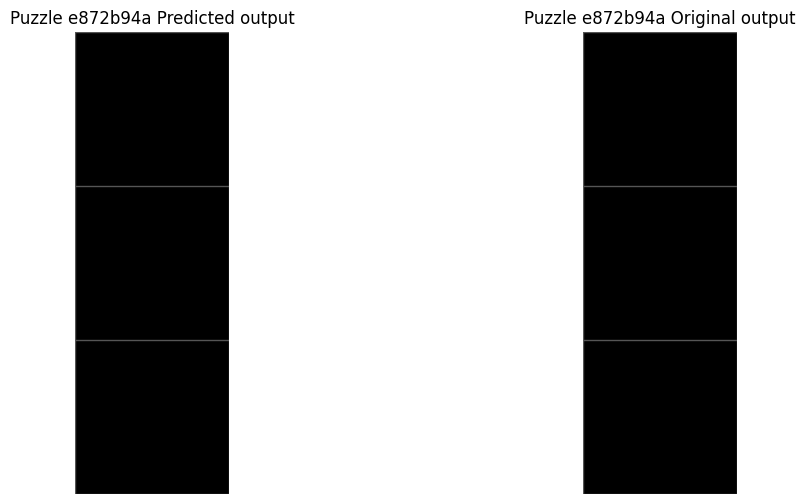

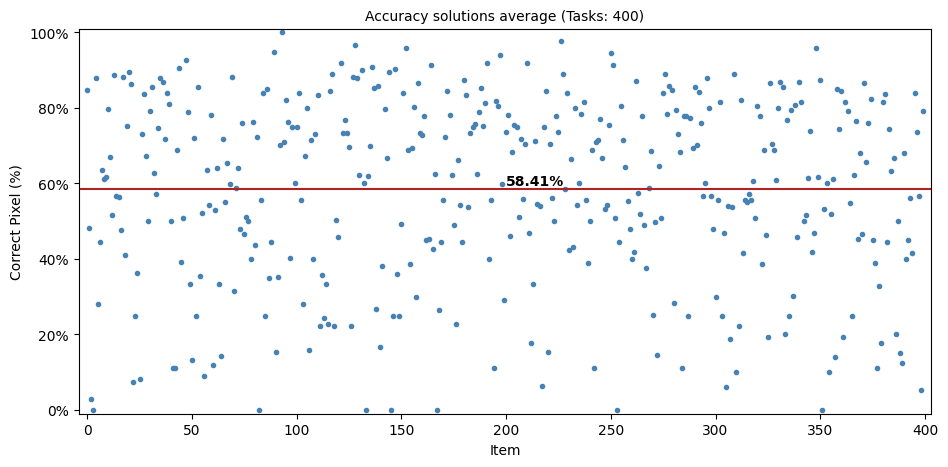

Number of 100% Correct: 1
Number of 90%+ Correct: 18
Number of 80%+ Correct: 87
Number of 70%+ Correct: 163
scaled_euc


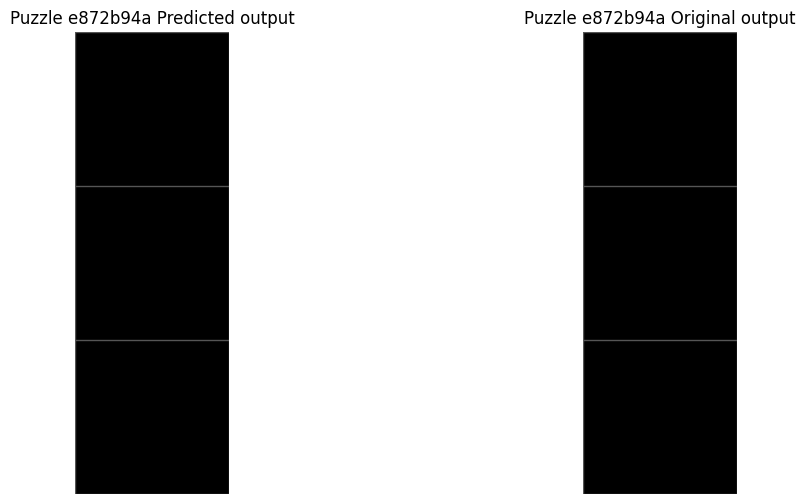

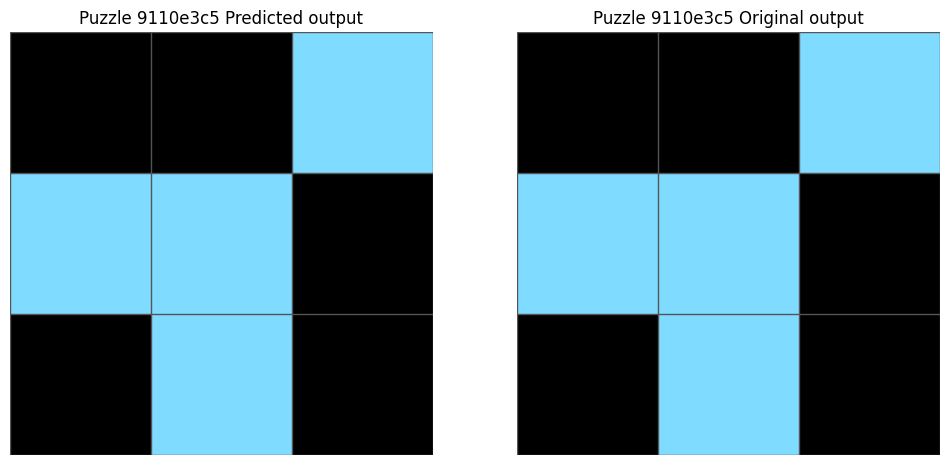

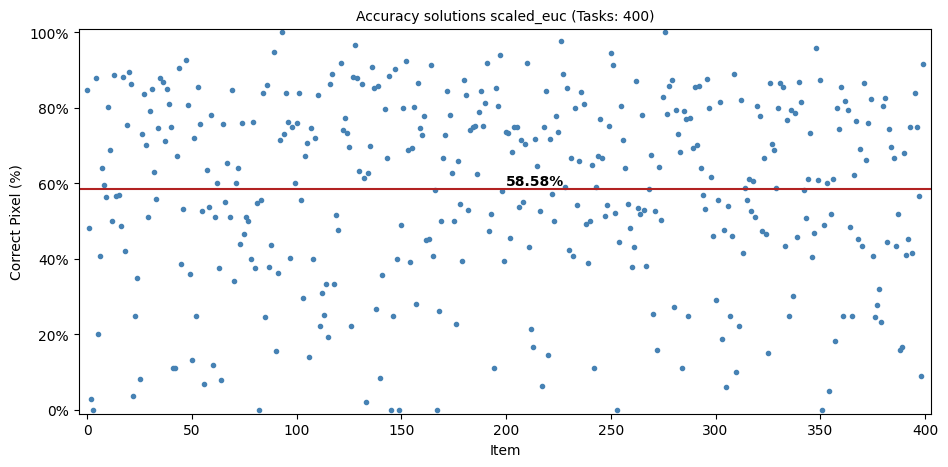

Number of 100% Correct: 2
Number of 90%+ Correct: 19
Number of 80%+ Correct: 90
Number of 70%+ Correct: 163
scaled_cos


/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_79791/956291478.py:86: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_diff
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_79791/956291478.py:86: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_diff
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_79791/956291478.py:86: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_diff
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_79791/956291478.py:86: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_d

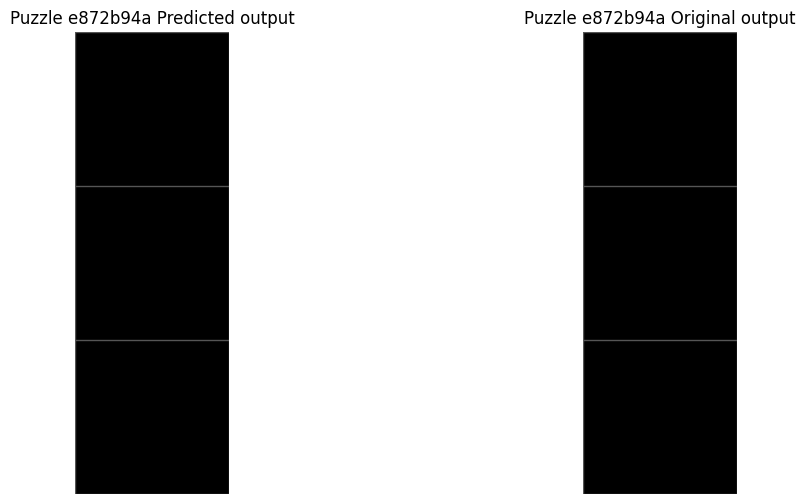

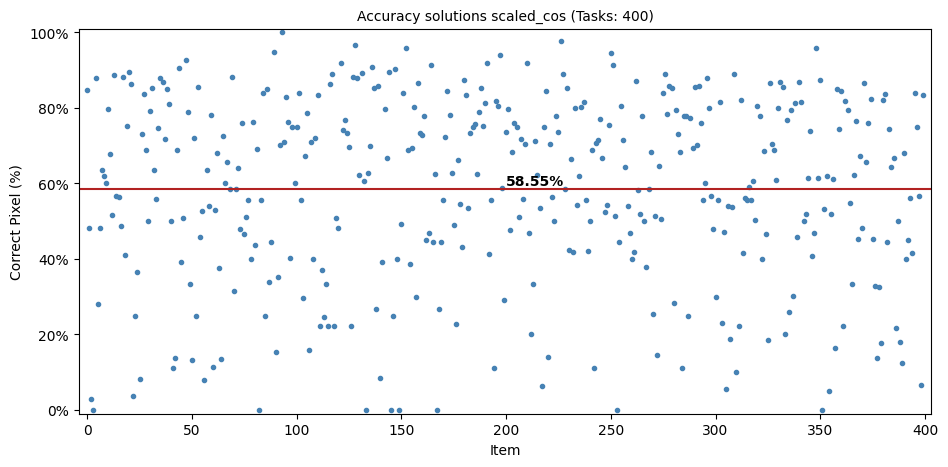

Number of 100% Correct: 1
Number of 90%+ Correct: 17
Number of 80%+ Correct: 89
Number of 70%+ Correct: 162
no_transform


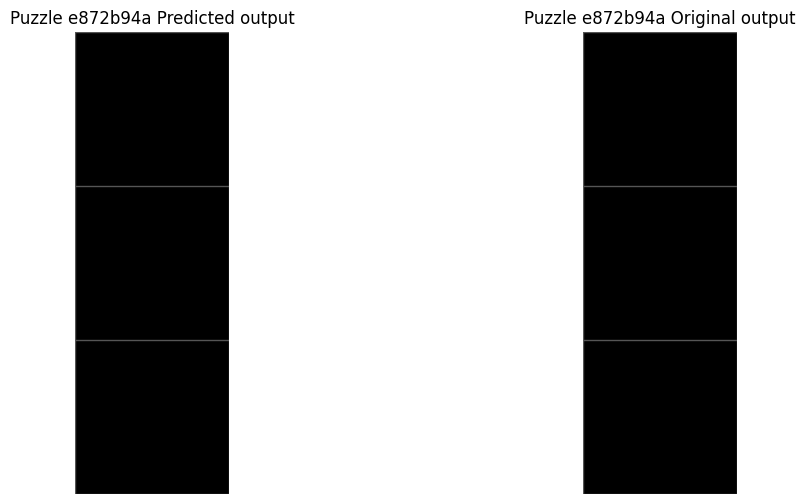

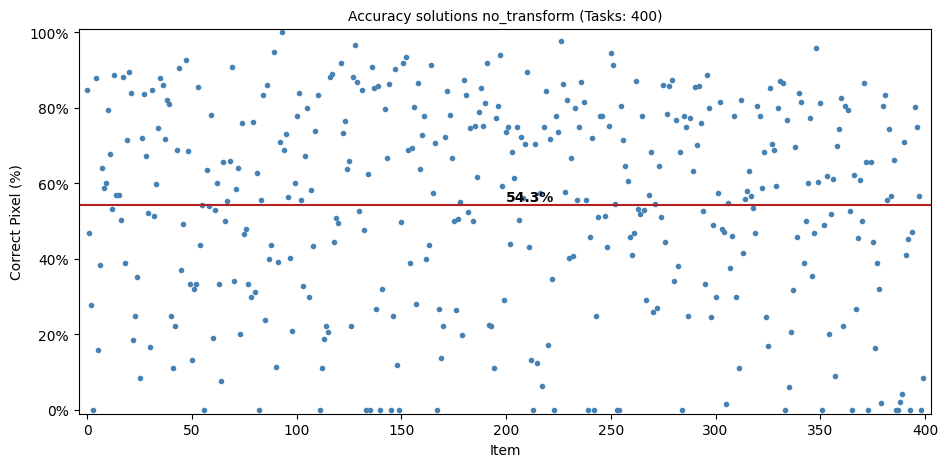

Number of 100% Correct: 1
Number of 90%+ Correct: 18
Number of 80%+ Correct: 81
Number of 70%+ Correct: 144


In [25]:
solved_puzzles = []

comps = ['average', 'scaled_euc', 'scaled_cos', 'no_transform']

def compute_accuracy(original, decoded):
        correct = (original == decoded)
        accuracy = correct.mean().item()
        is_perfect = accuracy == 1.0
        return accuracy, is_perfect

for comp in comps:
    print(comp)
    accuracies = []    

    for puzzle_id, task in data.items():
        
        pred, original = visual_analogy_single_task(
            pipeline=pipeline,
            train_pairs=task['train'],
            test_pair=task['test'][0],
            # model_type='vq',
            model_type='vae',
            comp=comp
        )

        acc, perfect = compute_accuracy(pred, original)
        accuracies.append(acc)

        if perfect:
            solved_puzzles.append(puzzle_id)

            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            draw_grid(axes[0], pred, f"Puzzle {puzzle_id} Predicted output")
            draw_grid(axes[1], original, f"Puzzle {puzzle_id} Original output")

    mean = np.mean(accuracies)

    ig, ax = plt.subplots(figsize=(11,5))
    plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
    plt.axhline(mean, xmax = len(accuracies), color='firebrick')
    plt.title(f'Accuracy solutions {comp} (Tasks: {len(accuracies)})', size='medium')
    plt.xlabel('Item')
    plt.ylabel('Correct Pixel (%)')
    plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
    plt.ylim(-0.01, 1.01)
    plt.margins(x=0.01)
    plt.show()

    print(f'Number of 100% Correct: {accuracies.count(1)}')
    print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
    print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
    print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')
        



average


/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_79791/956291478.py:86: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_diff


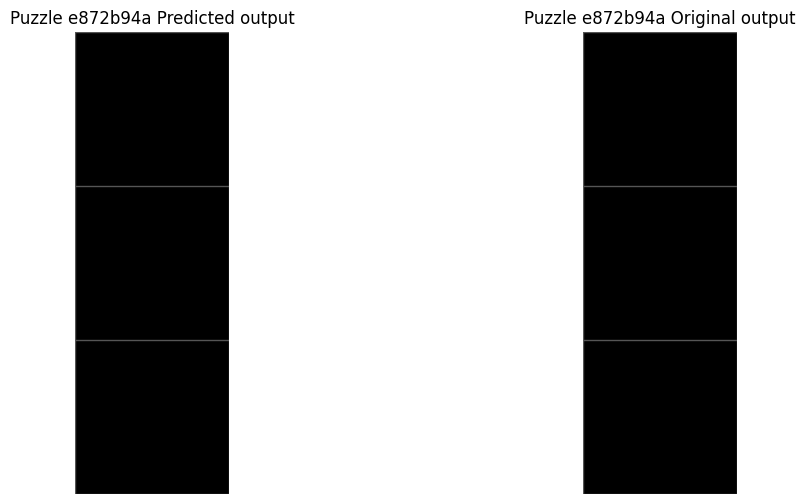

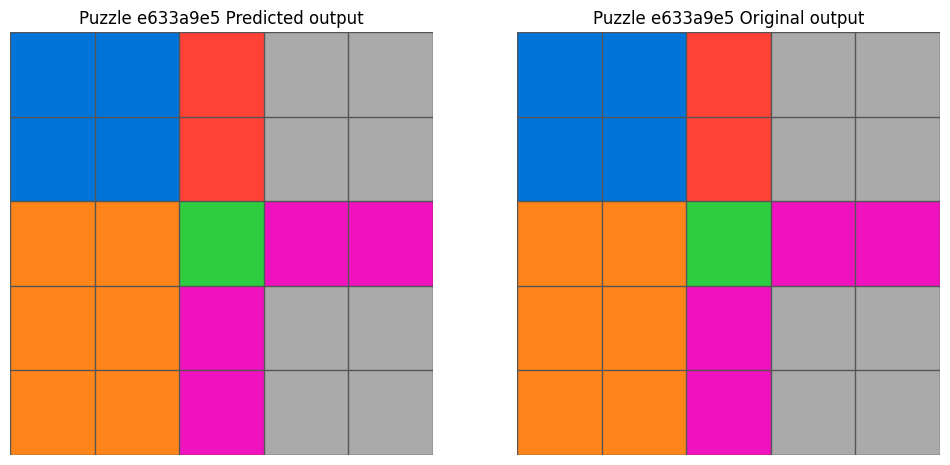

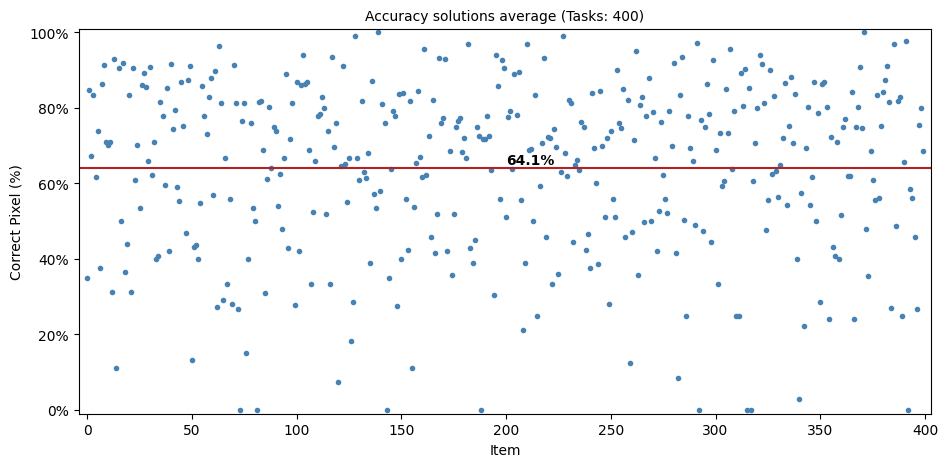

Number of 100% Correct: 2
Number of 90%+ Correct: 41
Number of 80%+ Correct: 117
Number of 70%+ Correct: 193
scaled_euc


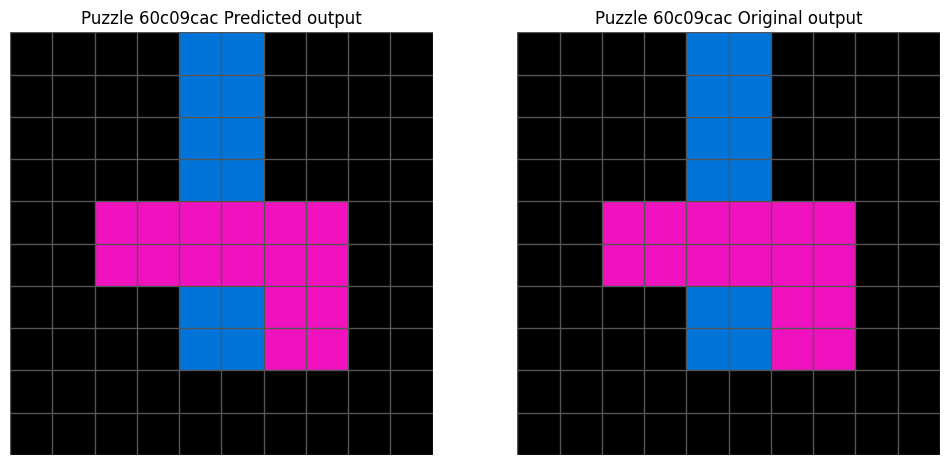

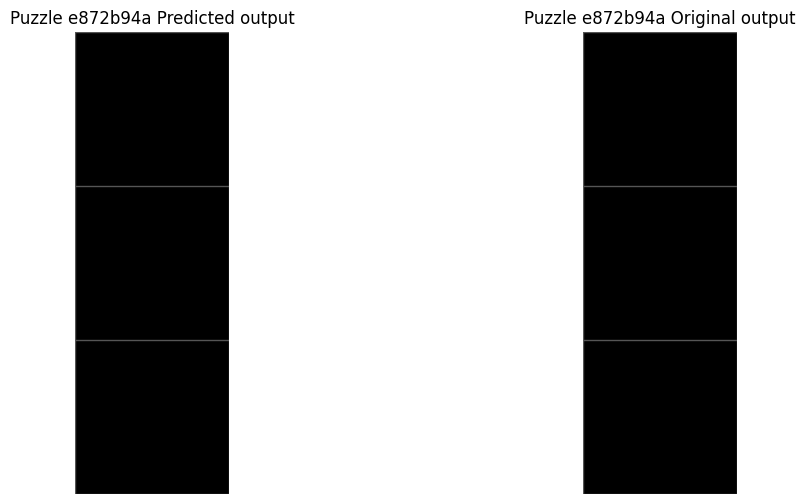

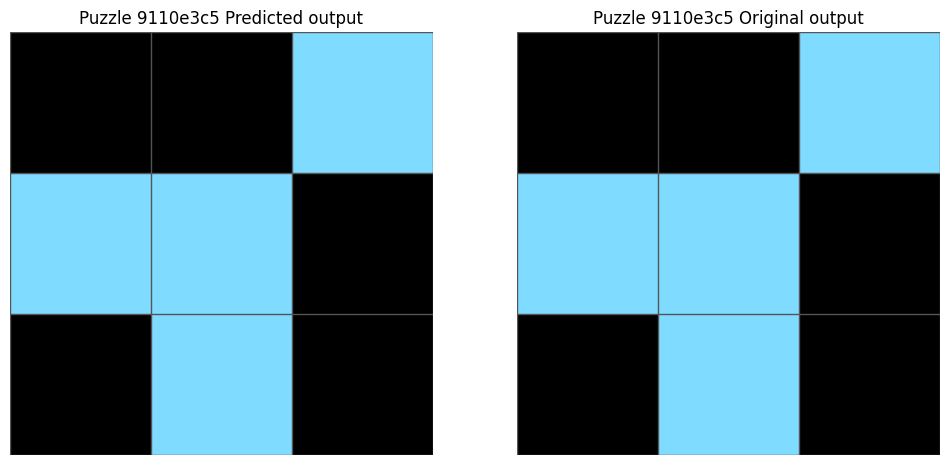

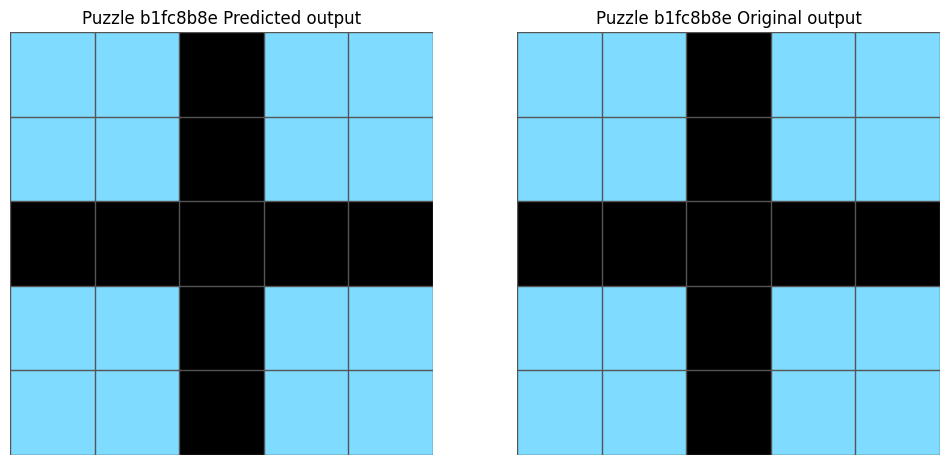

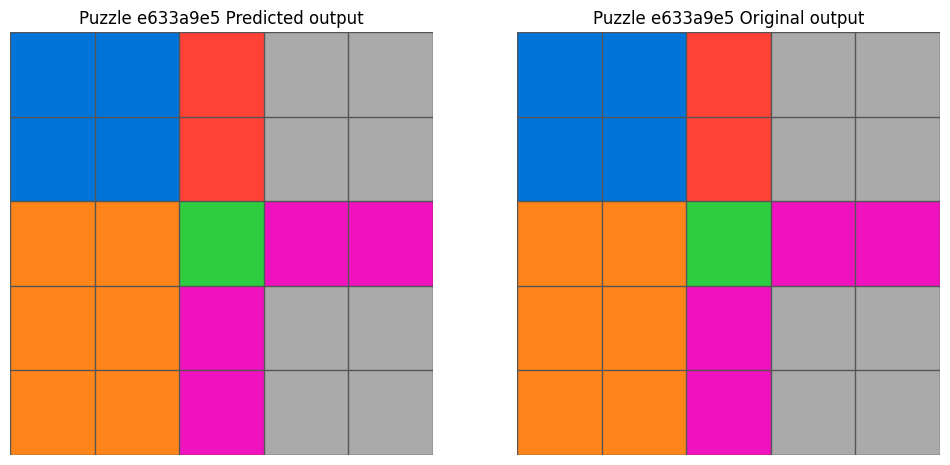

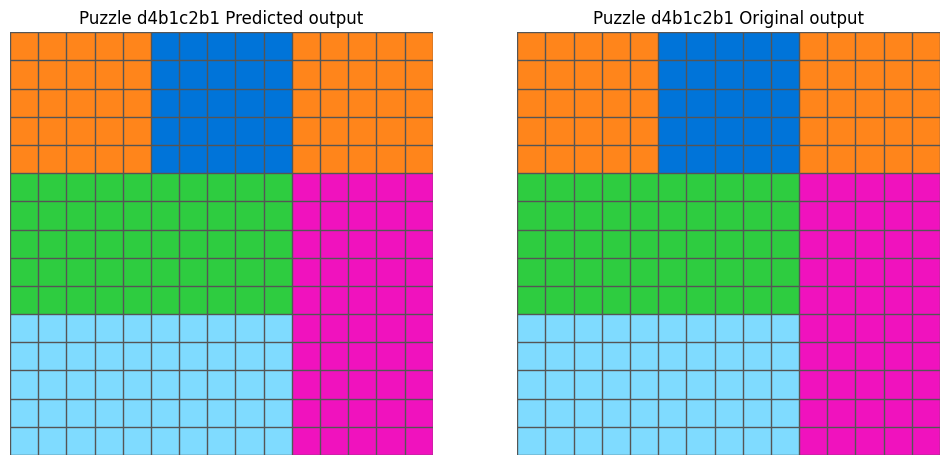

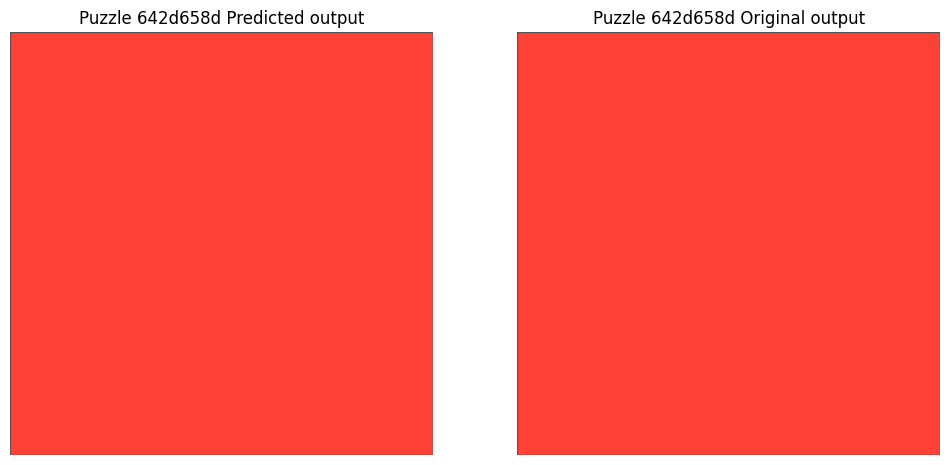

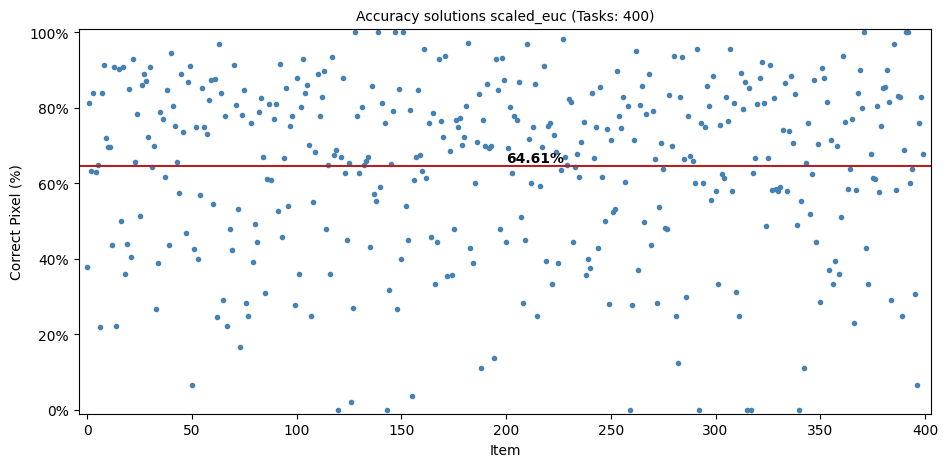

Number of 100% Correct: 7
Number of 90%+ Correct: 41
Number of 80%+ Correct: 123
Number of 70%+ Correct: 194
scaled_cos


/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_79791/956291478.py:86: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_diff
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_79791/956291478.py:86: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_diff
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_79791/956291478.py:86: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_diff
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_79791/956291478.py:86: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z_pred = z_test_input + z_d

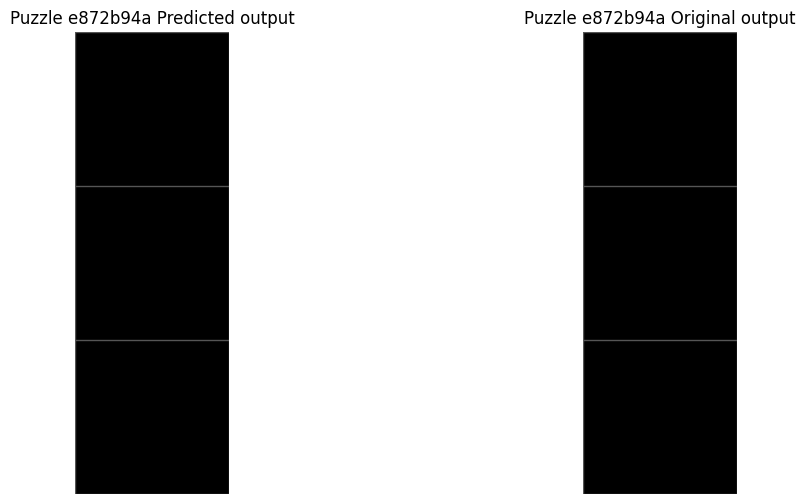

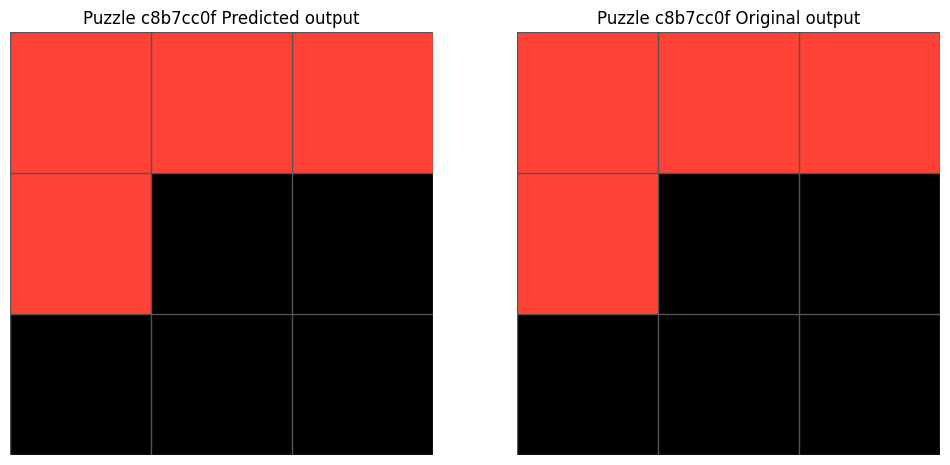

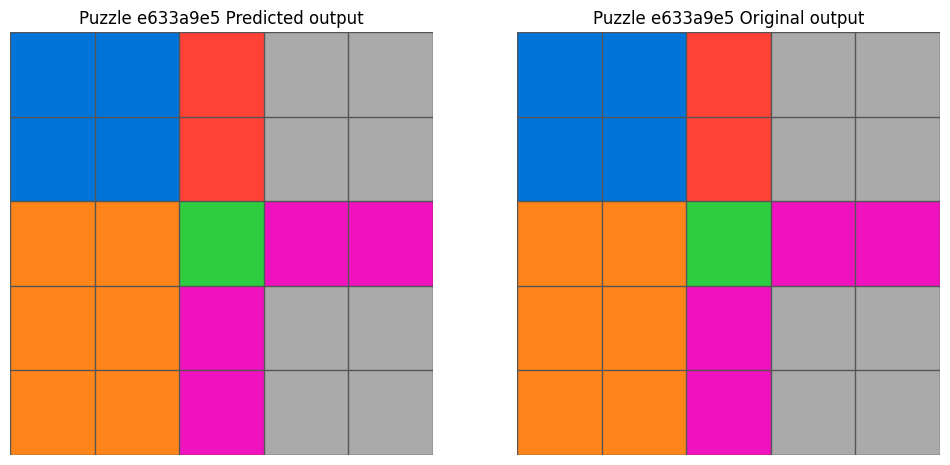

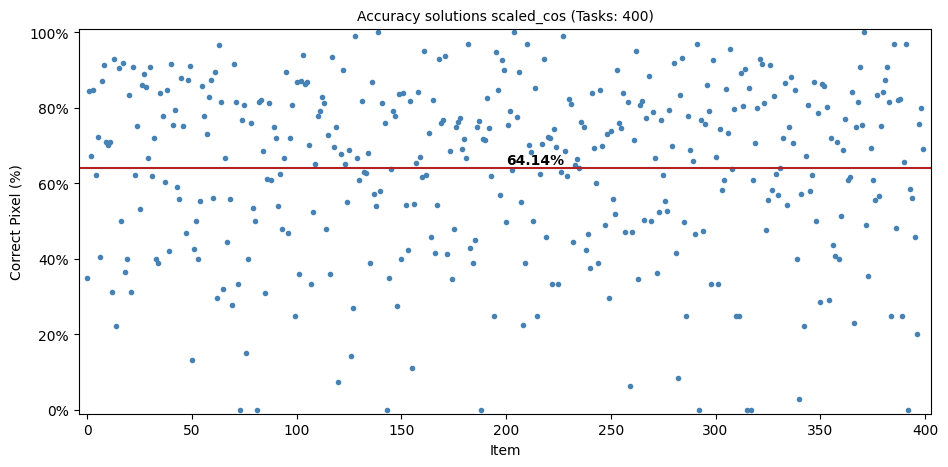

Number of 100% Correct: 3
Number of 90%+ Correct: 42
Number of 80%+ Correct: 118
Number of 70%+ Correct: 194
no_transform


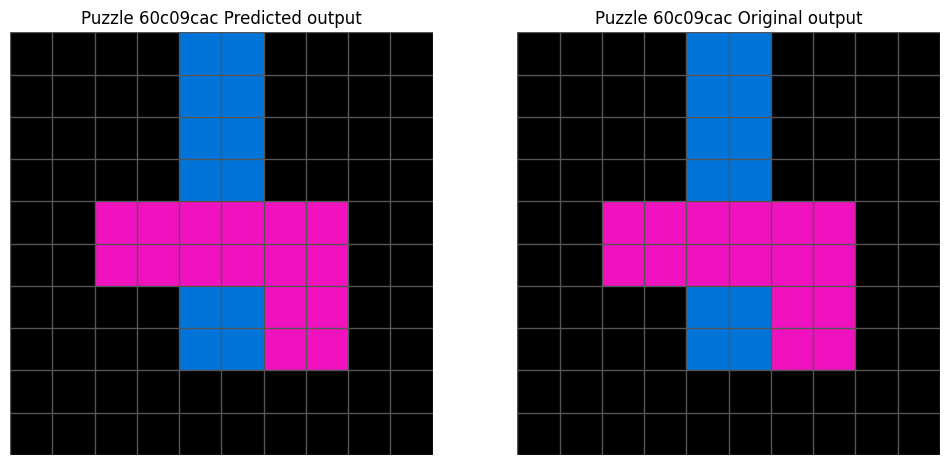

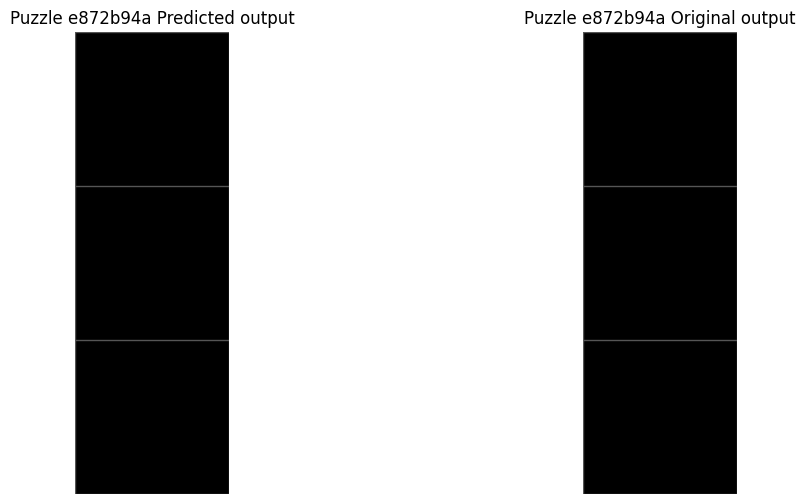

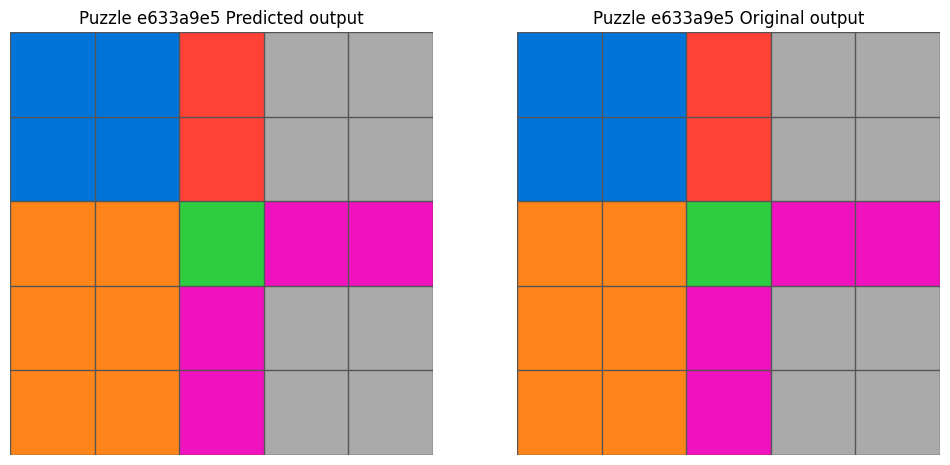

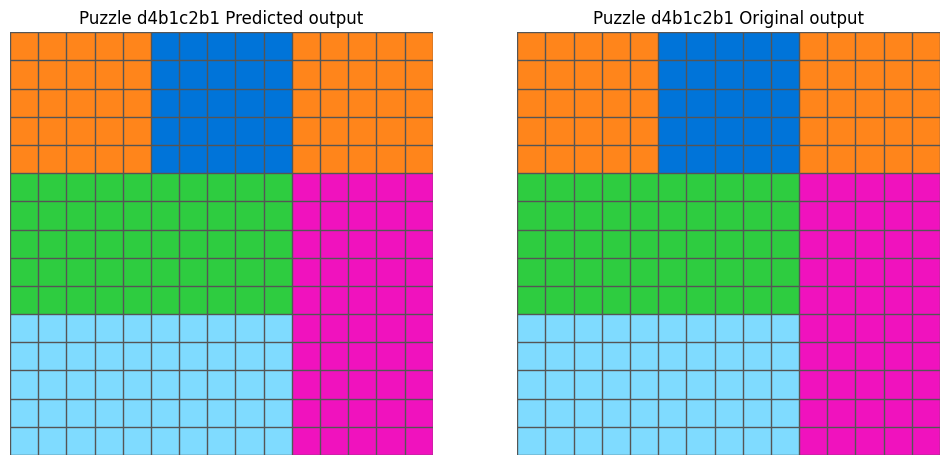

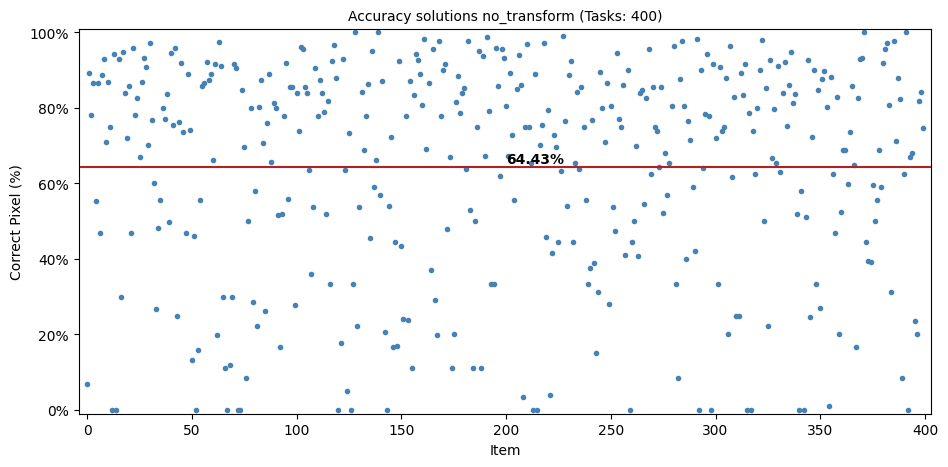

Number of 100% Correct: 4
Number of 90%+ Correct: 75
Number of 80%+ Correct: 164
Number of 70%+ Correct: 221


In [19]:
def reconstruct_grid(grid, expected_grid, model_type):
    grid = pipeline.preprocess_and_compress(grid)
    # print(grid.shape)
    grid = grid.unsqueeze(0)
    grid_decoded = grid

    if model_type == 'vq':
        z_e = pipeline.encode(grid)
        z_q, _, _ = pipeline.model.quantize(z_e)
        grid_decoded = pipeline.decode(z_q)
    else:
        z, _ = pipeline.encode(grid)
        grid_decoded = pipeline.decode(z)

    grid_decoded = pipeline.decompress_and_postprocess(grid_decoded.squeeze(0), expected_grid)
    return grid_decoded

def apply_reconstruction_error(pred, input, input_recon):
    if pred.shape != input.shape:
        return pred
    
    error = input - input_recon
    
    corrected_pred = pred + error
    
    return corrected_pred

# model_type = 'vq'
model_type = 'vae'
for comp in comps:
    print(comp)
    accuracies = []    

    for puzzle_id, task in data.items():
        test_pair = task['test'][0]
        pred, original = visual_analogy_single_task(
            pipeline=pipeline,
            train_pairs=task['train'],
            test_pair=test_pair,
            model_type=model_type,
            comp=comp
        )

        input, _ = test_pair
        input_recon = reconstruct_grid(input, input, model_type)

        pred = apply_reconstruction_error(pred, input, input_recon)

        acc, perfect = compute_accuracy(pred, original)
        accuracies.append(acc)

        if perfect:
            solved_puzzles.append(puzzle_id)

            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            draw_grid(axes[0], pred, f"Puzzle {puzzle_id} Predicted output")
            draw_grid(axes[1], original, f"Puzzle {puzzle_id} Original output")

    mean = np.mean(accuracies)

    ig, ax = plt.subplots(figsize=(11,5))
    plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
    plt.axhline(mean, xmax = len(accuracies), color='firebrick')
    plt.title(f'Accuracy solutions {comp} (Tasks: {len(accuracies)})', size='medium')
    plt.xlabel('Item')
    plt.ylabel('Correct Pixel (%)')
    plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
    plt.ylim(-0.01, 1.01)
    plt.margins(x=0.01)
    plt.show()

    print(f'Number of 100% Correct: {accuracies.count(1)}')
    print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
    print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
    print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')




In [21]:
print(set(solved_puzzles))

{'642d658d', 'b1fc8b8e', '9110e3c5', 'd4b1c2b1', 'c8b7cc0f', 'e872b94a', '60c09cac', 'e633a9e5'}
